<a href="https://colab.research.google.com/github/PabloJRW/TinyML-sineFunction/blob/main/TinyML_Sin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [ ]:
np.random.seed(12)
tf.random.set_seed(12)

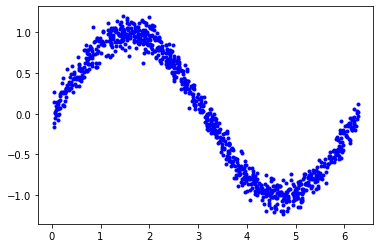

In [ ]:

x_values = np.random.uniform(low=0, high=2*math.pi, size=1000)

# Shuffle the values

# Calculate the corresponding sine values
y_values = np.sin(x_values)
# Adding noise
y_values += 0.1 * np.random.randn(*y_values.shape)

# 
plt.plot(x_values, y_values, 'b.')
plt.show()

In [ ]:
# Splitting the data
train_set = int(0.6 * len(x_values))
test_set = int(0.2 * len(x_values) + train_set)

train_set

600